# Change Detection Example: Log Ratio

This example shows how the Capella API can be used to fetch a time series stack of data, read data for a given bounding box directly from cloud optimized geotiffs stored in Capella's S3 bucket, and apply a log ratio change detection with an accumulator. To run this notebook, you will need a Capella API account, with credentials saved in a credentials.json file.

In [1]:
# Make the notebook interactive
#%matplotlib notebook

import requests
import json
import rasterio
import numpy as np
from pyproj import Transformer
from rasterio.plot import show
from rasterio.windows import Window
from skimage import exposure
from matplotlib import rcParams
from matplotlib import pyplot
from matplotlib import pyplot as plt
from scipy.ndimage import morphology
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

### Set up project variables

In [2]:
# Bounding box definition
bbox = [4.421052932739258, 51.8897361000644, 4.437961578369141, 51.89696629368307] # lower left corner, upper right corner in lon/lat 
timerange = "2019-08-01T00:00:00Z/2019-08-30T23:59:00Z"

# Threshold setting for change detection
THRSET = 2 

# Windows sizes for filtering
MORPHWINSIZE = 3 # window size for Morphological filtering
FILTSIZE = 3 # window size for speckle filter

### Utility Function to Print JSON 

In [3]:
# JSON utility function
def p(data):
    print(json.dumps(data, indent=2))

### Function to apply speckle filtering

In [4]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

### Function to reproject bounding box coordinates to the SAR data coordinate system

In [5]:
def reproject_bbox(bb, epsg):
    transformer = Transformer.from_crs("EPSG:4326", epsg, always_xy=True)
    obb = [0] * 4
    obb[0], obb[1] = transformer.transform(bb[0], bb[1])
    obb[2], obb[3] = transformer.transform(bb[2], bb[3])
    return obb   

### Load API credentials and get an API token

In [6]:
# Load username and password
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

In [7]:
# Get token
r = requests.post('https://api.capellaspace.com/token', 
                  headers = {'Content-Type': 'application/x-www-form-urlencoded'}, auth=(username,password))
accesstoken = r.json()["accessToken"]
headers = {'Authorization':'Bearer ' + accesstoken}

### Use the API to search for Capella SAR data

In [8]:
# Post search filters
filters = {
    "datetime": timerange,
    "bbox": bbox,
    "collections": ["rotterdam-aerial-mosaic"],
    "query": {"sar:instrument_mode": {"eq": "stripmap"},  
            "sar:product_type": {"eq":"GEO"}},
    "sort": ["dtr:start_datetime"],
    "limit": 50
}

headers = {'Content-Type': 'application/json',
  'Accept': 'application/geo+json', 'Authorization':'Bearer ' + accesstoken}
r = requests.post('https://api.capellaspace.com/catalog/search', json=filters, headers=headers)

# Inspect the results
#p(r.json())

In [9]:
# Build the Order
granulelist = []

# Loop over all the features from the response and add to an array for an order
for f in r.json()["features"]:
    item = {"CollectionId": f["collection"], "GranuleId": f["id"]}
    granulelist.append(item)
    
myorder = {"Items": granulelist}

# Post the order and inspect the result
r = requests.post('https://api.capellaspace.com/orders', json=myorder, headers=headers)

In [10]:
myorderid = r.json()["orderId"]
r = requests.get('https://api.capellaspace.com/orders/' + myorderid + '/download', headers=headers)

### Build a change heatmap from the time series

Ingests images two at a time by reading only the area within the bounding box from the cloud optimized geotiffs, speckle filters the images, performs log ratio change detection, thresholds and saves detection map into an accumulator, process repeats through all image pairs and builds a heatmap of change

In [11]:
# Read files in two at a time and speckle filters

features = r.json()
n = len(features)
print("There are " + str(n) + " images to be analyzed.")

# Open the file with Rasterio
Session = rasterio.Env(
            GDAL_DISABLE_READDIR_ON_OPEN='YES',
            CPL_VSIL_CURL_USE_HEAD='NO',
            )

for i in range(0,n-1):   
    with Session:
        filepath = features[i]["assets"]["HH"]["href"]
        with rasterio.open(filepath) as src:
            meta = src.meta
            rbbox = reproject_bbox(bbox, src.crs)
            w = rasterio.windows.from_bounds(rbbox[0], rbbox[1], rbbox[2], rbbox[3], src.transform)
            img1 = src.read(1, window=w)
            img1[img1 == meta['nodata']] = 0
            lee_filt_img1 = lee_filter(img1, FILTSIZE)
        filepath = features[i+1]["assets"]["HH"]["href"]
        with rasterio.open(filepath) as src:
            meta = src.meta
            rbbox = reproject_bbox(bbox, src.crs)
            w = rasterio.windows.from_bounds(rbbox[0], rbbox[1], rbbox[2], rbbox[3], src.transform)
            img2 = src.read(1, window=w)
            img2[img2 == meta['nodata']] = 0
            lee_filt_img2 = lee_filter(img2, FILTSIZE)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')
    
    # Calculate the log ratio of image pairs
    dIx = np.log(lee_filt_img2/lee_filt_img1)
    
    # Statistics and thresholding
    # Thresholding is empirically derived, requires manual adjustment of THRSET constant
    thr = np.nanmean(dIx) + THRSET*np.nanstd(dIx)
    dIx[dIx < thr] = 0.0
    dIx[dIx > thr] = 1.0

    # Morphological opening to reduce false alarms    
    w = (MORPHWINSIZE, MORPHWINSIZE)
    dIx = morphology.grey_opening(dIx, size=w)
    
    # Build accumulator
    if i == 0:
        cd = dIx
    else:
        cd += dIx

There are 14 images to be analyzed.


### Display the change detection result

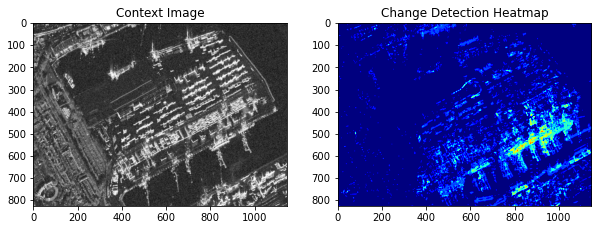

In [12]:
with Session:
        filepath = features[0]["assets"]["HH"]["href"]
        with rasterio.open(filepath) as src:
            meta = src.meta
            rbbox = reproject_bbox(bbox, src.crs)
            w = rasterio.windows.from_bounds(rbbox[0], rbbox[1], rbbox[2], rbbox[3], src.transform)
            ci = src.read(1, window=w)
            ci[ci == meta['nodata']] = 0
            ci = lee_filter(ci, FILTSIZE)
            ci = exposure.adjust_log(ci, gain=10)

rcParams['figure.figsize'] = 10,5
fig, ax = plt.subplots(1,2)
ax[0].imshow(ci, 'gray');
ax[0].set_title("Context Image");
ax[1].imshow(cd, cmap='jet');
ax[1].set_title("Change Detection Heatmap");